In [1]:
import pandas as pd
import numpy as np

#import datetime
from datetime import datetime, date, timedelta
import time

from yahooquery import Ticker

import requests
import json

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import xlwings as xw




In [2]:

wb = xw.Book("daily.xlsm")
sht2 = wb.sheets['options_chain']
sht3 = wb.sheets['ticker_list']
sht1 = wb.sheets['correl']

In [3]:
shtlist= sht3.range('A1').options(pd.DataFrame, 
                             header=False,
                             index=False, 
                             expand='table').value

In [4]:
stonks=shtlist.iloc[1:,0].tolist()

In [5]:
stonks

['MSFT',
 'AAPL',
 'AMZN',
 'GOOG',
 'GOOGL',
 'NVDA',
 'TSLA',
 'META',
 'PEP',
 'AVGO',
 'COST',
 'CSCO',
 'TMUS',
 'ADBE',
 'CMCSA',
 'TXN',
 'HON',
 'AMGN',
 'NFLX',
 'QCOM',
 'SBUX',
 'INTU',
 'INTC',
 'GILD',
 'AMD',
 'QQQ',
 'KO',
 'SBUX',
 'WMT',
 'JNJ',
 'PG',
 'UVXY',
 'SPY',
 'HD',
 'USO']

In [6]:

stonks2 = Ticker(stonks, asynchronous=True)

In [7]:
# 90 days worth of data
d = datetime.today() - timedelta(days=120)
yq_data = stonks2.history(start=d, interval='1d')

In [8]:
yq_data.reset_index(inplace=True)
yq_data

,symbol,date,open,low,volume,close,high,adjclose,dividends
0,MSFT,2022-09-02,261.700012,254.470001,22855400,256.059998,264.739990,255.340408,0.0
1,MSFT,2022-09-06,256.200012,251.940002,21328200,253.250000,257.829987,252.538300,0.0
2,MSFT,2022-09-07,254.699997,253.220001,24126700,258.089996,258.829987,257.364716,0.0
3,MSFT,2022-09-08,257.510010,254.789993,20319900,258.519989,260.429993,257.793488,0.0
4,MSFT,2022-09-09,260.500000,260.290009,22084700,264.459991,265.230011,263.716797,0.0
...,...,...,...,...,...,...,...,...,...
2817,USO,2022-12-23,68.940002,68.870003,2928200,69.320000,69.559998,69.320000,0.0
2818,USO,2022-12-27,69.589996,69.059998,3147900,69.529999,70.540001,69.529999,0.0
2819,USO,2022-12-28,69.180000,67.529999,2782800,68.580002,69.220001,68.580002,0.0
2820,USO,2022-12-29,67.550003,67.370003,1972300,68.529999,68.589996,68.529999,0.0


In [9]:
#get latest volume
today_volume = yq_data.groupby('symbol')['volume'].last().to_dict()

In [10]:
# drop columns that are not used
yq_data = yq_data.drop(columns = ['open', 'low', 'close', 'high'])# 'dividends'])

In [11]:
# calculate log return using daily historical price data
yq_data = yq_data.assign(logret=np.log(yq_data.adjclose).groupby(yq_data.symbol).diff()) 

In [12]:
yq_data2 = yq_data[["date", "symbol","logret"]]

In [13]:
yq_data2

,date,symbol,logret
0,2022-09-02,MSFT,NaN
1,2022-09-06,MSFT,-0.011035
2,2022-09-07,MSFT,0.018931
3,2022-09-08,MSFT,0.001665
4,2022-09-09,MSFT,0.022717
...,...,...,...
2817,2022-12-23,USO,0.023647
2818,2022-12-27,USO,0.003025
2819,2022-12-28,USO,-0.013757
2820,2022-12-29,USO,-0.000729


In [14]:
yq_data2.set_index('date')

,symbol,logret
date,,
2022-09-02,MSFT,NaN
2022-09-06,MSFT,-0.011035
2022-09-07,MSFT,0.018931
2022-09-08,MSFT,0.001665
2022-09-09,MSFT,0.022717
...,...,...
2022-12-23,USO,0.023647
2022-12-27,USO,0.003025
2022-12-28,USO,-0.013757


In [15]:
yq_dataT=yq_data2.pivot_table(index = ["date"], 
              columns = "symbol" , 
              values = "logret", 
              aggfunc = "sum",
              fill_value = "").reset_index()

In [16]:
yq_dataT.head()

symbol,date,AAPL,ADBE,AMD,AMGN,AMZN,AVGO,CMCSA,COST,CSCO,...,QCOM,QQQ,SBUX,SPY,TMUS,TSLA,TXN,USO,UVXY,WMT
0,2022-09-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2022-09-06,-0.008249,0.000434,-0.019125,-0.000619,-0.011040,-0.004046,-0.028938,-0.000405,-0.002695,...,-0.014188,-0.007208,0.018871,-0.003780,-0.000493,0.015460,0.000613,-0.000140,0.030654,-0.004975
2,2022-09-07,0.009211,0.030536,0.011242,0.010554,0.026372,0.013814,0.006885,0.020486,0.012292,...,0.015122,0.020000,0.043865,0.017805,0.024983,0.033258,0.016539,-0.054674,-0.085640,0.025367
3,2022-09-08,-0.009664,0.010244,0.039047,0.002693,0.002623,0.013372,-0.017592,-0.000982,0.007744,...,0.001942,0.005171,0.012938,0.006515,-0.000894,0.019409,0.015499,0.006926,-0.023922,0.005070
4,2022-09-09,0.018664,0.028650,0.031745,0.009085,0.026228,0.020246,0.030375,0.014000,0.008778,...,0.024532,0.021627,-0.008644,0.015416,0.002268,0.035389,0.013740,0.043257,-0.015915,0.003001


In [17]:
# variance - covariance Matrix
cov_matrix = yq_dataT.cov()
cov_matrix

symbol,AAPL,ADBE,AMD,AMGN,AMZN,AVGO,CMCSA,COST,CSCO,GILD,...,QCOM,QQQ,SBUX,SPY,TMUS,TSLA,TXN,USO,UVXY,WMT
symbol,,,,,,,,,,,,,,,,,,,,,
AAPL,0.000616,0.000516,0.000688,1.216436e-04,0.000493,0.000447,0.000333,0.000301,0.000311,0.000270,...,0.000589,0.000444,0.000259,0.000340,0.000227,0.000490,0.000410,1.421680e-04,-0.000595,0.000176
ADBE,0.000516,0.001034,0.000675,1.520135e-04,0.000565,0.000484,0.000397,0.000298,0.000310,0.000198,...,0.000618,0.000453,0.000236,0.000348,0.000202,0.000344,0.000420,2.443927e-04,-0.000599,0.000168
AMD,0.000688,0.000675,0.001382,1.707529e-04,0.000743,0.000646,0.000503,0.000432,0.000423,0.000296,...,0.000757,0.000622,0.000440,0.000480,0.000265,0.000763,0.000605,2.207110e-04,-0.000969,0.000268
AMGN,0.000122,0.000152,0.000171,2.528571e-04,0.000075,0.000110,0.000128,0.000127,0.000116,0.000142,...,0.000136,0.000111,0.000077,0.000104,0.000129,0.000012,0.000122,8.416227e-07,-0.000203,0.000081
AMZN,0.000493,0.000565,0.000743,7.482615e-05,0.000868,0.000465,0.000386,0.000335,0.000282,0.000077,...,0.000547,0.000482,0.000330,0.000368,0.000127,0.000590,0.000404,1.957575e-04,-0.000683,0.000192
AVGO,0.000447,0.000484,0.000646,1.104669e-04,0.000465,0.000516,0.000325,0.000273,0.000280,0.000221,...,0.000564,0.000394,0.000280,0.000313,0.000178,0.000409,0.000395,2.306665e-04,-0.000604,0.000144
CMCSA,0.000333,0.000397,0.000503,1.275601e-04,0.000386,0.000325,0.000417,0.000214,0.000239,0.000148,...,0.000383,0.000307,0.000205,0.000256,0.000145,0.000252,0.000290,1.778723e-04,-0.000540,0.000119
COST,0.000301,0.000298,0.000432,1.271297e-04,0.000335,0.000273,0.000214,0.000346,0.000192,0.000179,...,0.000299,0.000266,0.000143,0.000218,0.000160,0.000309,0.000250,8.833595e-05,-0.000410,0.000163
CSCO,0.000311,0.000310,0.000423,1.161316e-04,0.000282,0.000280,0.000239,0.000192,0.000266,0.000179,...,0.000354,0.000262,0.000186,0.000218,0.000174,0.000234,0.000253,9.959875e-05,-0.000466,0.000118


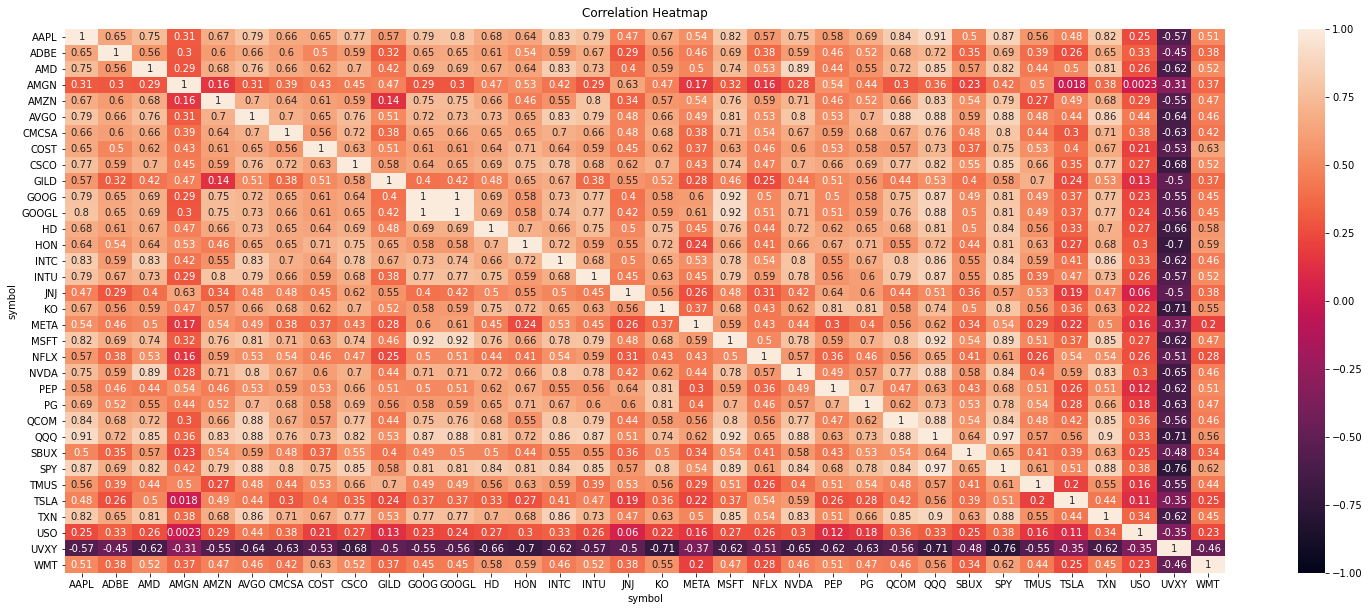

In [18]:
#correlation matricx

plt.figure(figsize=(26, 10))
heatmap1 = sns.heatmap(yq_dataT.corr(), vmin=-1, vmax=1, annot=True)

heatmap1.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

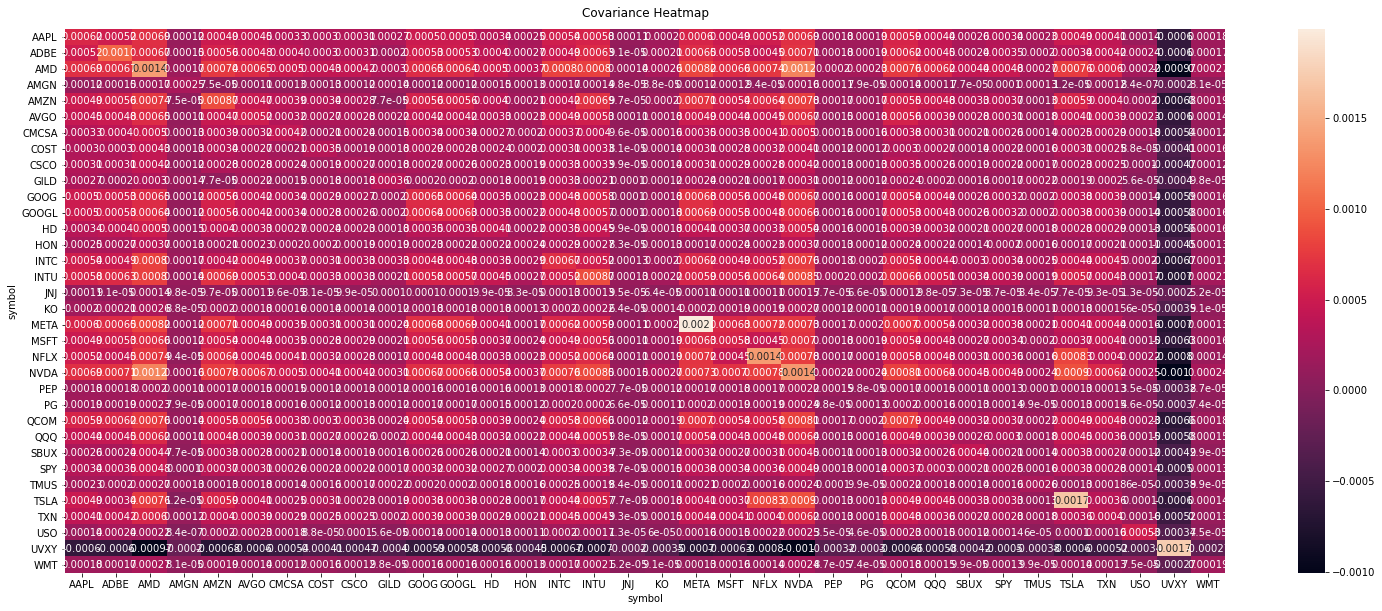

In [19]:
plt.figure(figsize=(26, 10))
heatmap2 = sns.heatmap(cov_matrix, annot=True)

heatmap2.set_title('Covariance Heatmap', fontdict={'fontsize':12}, pad=12);

In [20]:
avg_rets = yq_dataT.mean()
avg_rets

symbol
AAPL    -0.002168
ADBE    -0.001082
AMD     -0.002580
AMGN     0.001050
AMZN    -0.005029
AVGO     0.001542
CMCSA   -0.000162
COST    -0.001527
CSCO     0.000909
GILD     0.003808
GOOG    -0.002443
GOOGL   -0.002419
HD       0.001023
HON      0.001708
INTC    -0.001845
INTU    -0.000896
JNJ      0.001066
KO       0.000648
META    -0.003456
MSFT    -0.000756
NFLX     0.003199
NVDA     0.000831
PEP      0.000761
PG       0.001288
QCOM    -0.001801
QQQ     -0.001191
SBUX     0.002226
SPY     -0.000201
TMUS    -0.000169
TSLA    -0.009464
TXN      0.000259
USO     -0.000225
UVXY    -0.004873
WMT      0.000816
dtype: float64

Text(0.5, 1.0, 'Stock Daily returns')

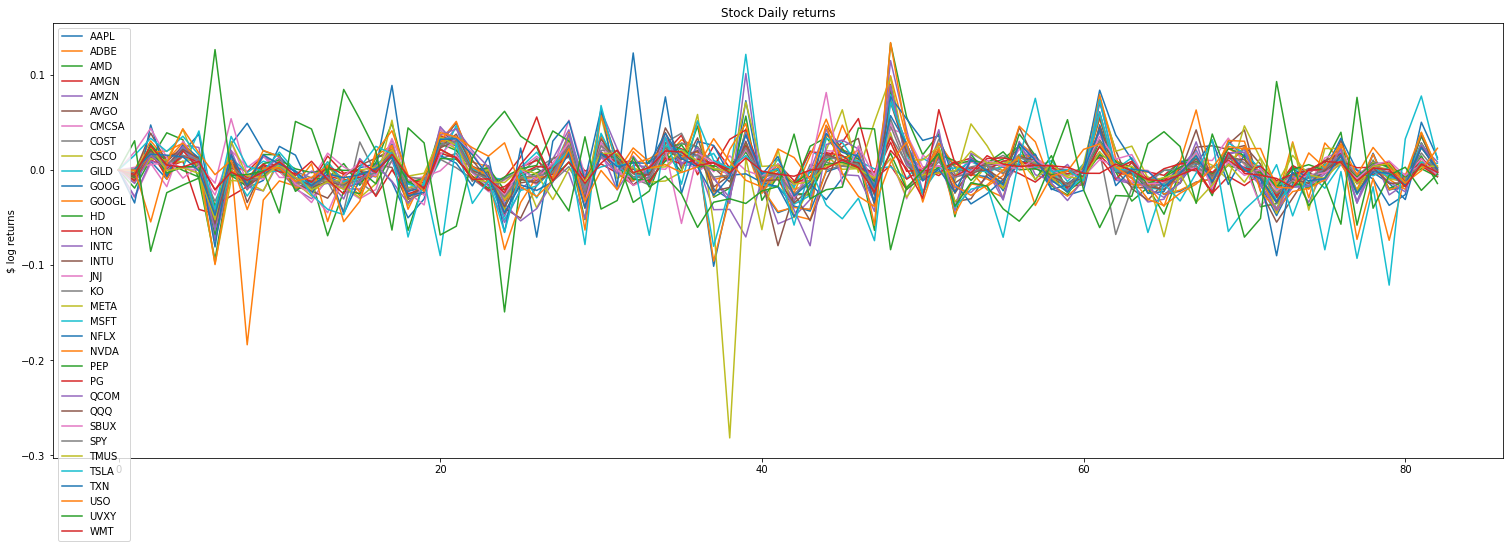

In [21]:
# Plot returns
yq_dataT.plot(figsize=(26,8))
plt.legend(loc='upper left')
plt.ylabel("$ log returns")
plt.title("Stock Daily returns")


In [22]:
sht1["A1"].options(pd.DataFrame, index=False, header=1,expand='table').value = yq_dataT.corr().reset_index()

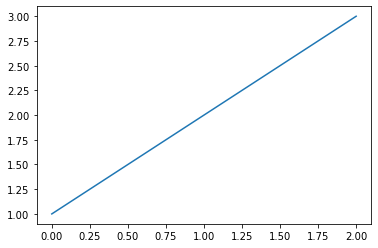

In [25]:
#fig = plt.figure()
#plt.plot([1, 2, 3])

In [26]:
#sht1.pictures.add(fig, name='MyPlot', update=True)

<Picture 'MyPlot' in <Sheet [daily.xlsm]test>>